# Week 7 - Temporal models 

## Part 4: Road traffic - Time-series imputation (with multivariate LDS)

In this part, we will specify a **multivariate** linear dynamical system (LDS) in STAN in order to do **imputation** on the freeway occupancy rates. The intuition is rather simple:
- Based on our domain knowledge about the problem, we know that freeway occupancy rates at nearby road segments should be highly correlated (cars don't just disappear; they must go somewhere!). Therefore, time-series observations from nearby sensors should also reflect these correlations.
- We can thus exploit these correlations and use the related time-series from nearby sensors (which probably will itself have missing observations) in order to help us do imputation on the time-series from a given sensor.

In this notebook, we will **use a multivariate LDS in order to explore these correlations and try to improve our imputations**.

The usual imports...

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). Although we will focus only on the data from two detectors as an example...

Load data:

In [3]:
# load csv
df = pd.read_csv("PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [4]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

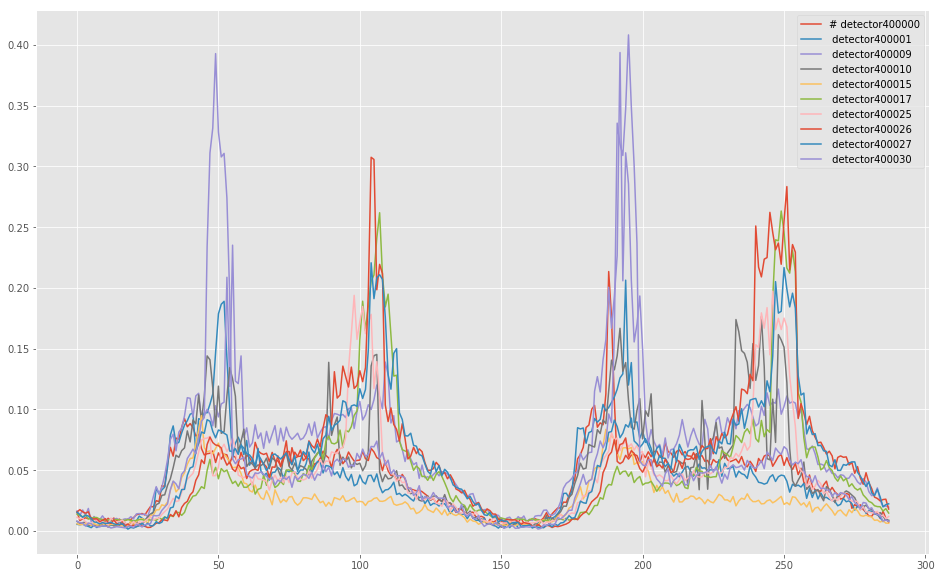

In [5]:
plt.plot(df[:(2*24*6)]) # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Lets now generate some artificial missing data at random. To make things challenging, we will consider a difficult setting were **80% of the observations are missing**. 

Notice that we save the real observations for the 80% missings, in order to evaluate the accuracy of our imputations later on.

Also, **note that both of the time-series (of the two detectors) that we will be using in this notebook have 80% of missing observations!**

In [6]:
# convert data to a matrix
y = df.values
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=10


In [7]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 29
N_mis: 115


Lets try implement a multivariate LDS in STAN! The model will have quite a few similaries with the one from the previous notebook (i.e. part 3), but also some significant changes:
- The first thing to notice is that we will now have two time-series instead of one! We therefore should make changes accordingly.
- We will model the correlations between the two series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or, if you prefer (equivalent!):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}
- The key element in the simple model described above is the **covariance matrix $\boldsymbol\Sigma$**! This is the object that will allow us to capture the correlations between the two time-series. We therefore need it to be a full matrix (i.e. rather than a isotropic covariance matrix of the form $\boldsymbol\Sigma = \sigma^2 \textbf{I}$)! Do you understand why?
- However, covariance matrices have certain well-known properties such as symmetry. Therefore, if we parameterize the full matrix $\boldsymbol\Sigma$, we will have redundant parameters (due to symmetry). This is often a bad idea, which can lead to several problems such as overfitting, numerical issues, poor convergence, etc. 
- A much better idea is to use a Cholesky decomposition of $\boldsymbol\Sigma$, such that $\boldsymbol\Sigma = \textbf{L}_{\boldsymbol\Sigma} \textbf{L}_{\boldsymbol\Sigma}^T$, where $\textbf{L}_{\boldsymbol\Sigma}$ is a lower triangular matrix with real and positive diagonal entries, and $\textbf{L}_{\boldsymbol\Sigma}^T$ denotes the transpose of $\textbf{L}_{\boldsymbol\Sigma}$. (You can read about the Cholesky decompostion here: https://en.wikipedia.org/wiki/Cholesky_decomposition)
- In this way, what we want is to do inference on the matrix $\textbf{L}_{\boldsymbol\Sigma}$. The problem is that this is still complicated to do in a Bayesian sense (e.g. which prior to use?). Fortunately, the solution is relatively simple. We need to consider another equivalence:
\begin{align}
\boldsymbol\Sigma = \mbox{diag}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag}(\boldsymbol\tau)
\end{align}
where $\mbox{diag}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal element given by the vector $\boldsymbol\tau$, a vector of coefficient scales, and $\boldsymbol\Omega$ is the correlation matrix.

- Since the matrix $\boldsymbol\Omega$ is also positive definite, this implies that $\boldsymbol\Omega=L_{\boldsymbol\Omega}L_{\boldsymbol\Omega}^T$, hence
\begin{align}
\boldsymbol\Sigma = \textbf{L}_{\boldsymbol\Sigma} \textbf{L}_{\boldsymbol\Sigma}^T=\mbox{diag}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag}(\boldsymbol\tau)=\mbox{diag}(\boldsymbol\tau) \, L_{\boldsymbol\Omega}L_{\boldsymbol\Omega}^T \, \mbox{diag}(\boldsymbol\tau)
\end{align}


- In other words, 
\begin{align}
\textbf{L}_{\boldsymbol\Sigma}=\mbox{diag}(\boldsymbol\tau) \, L_{\boldsymbol\Omega}
\end{align}

- So the actual parameters to estimate become $\boldsymbol\tau$ and $L_{\boldsymbol\Omega}$, and for those there are known (and implemented in STAN) solutions. Of course, we now estimate the $L_{\boldsymbol\Sigma}$ that we are looking for in transformed parameters section. Check the specific STAN data type (cholesky_factor_corr) and function (diag_pre_multiply). 

parameters {

    vector<lower=0>[2] tau;
    cholesky_factor_corr[2] L_omega;
    
}

transformed parameters {

    L_sigma = diag_pre_multiply(tau, L_omega);
    
}

Finally, we can then specify the multivariate normal distribution using $L_{\boldsymbol\Sigma}$ in the "model" block using:

z ~ multi_normal_cholesky(mu, L_sigma); 

And we need to place a particular prior on $\boldsymbol\Omega$, called the LKJ prior:

L_omega ~ lkj_corr_cholesky(10.0)

The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but we recommend something weakly informative like a half-Cauchy distribution with a small scale, such as (don't forget to put the constraint of making tau>=0):

tau ~ cauchy(0,1);


In [8]:
# define Stan model
model_definition = """
data {
  int<lower = 0>                         N_obs;
  int<lower = 0>                         N_mis;
  int<lower = 1, upper = N_obs + N_mis>  ix_obs1[N_obs];  
  int<lower = 1, upper = N_obs + N_mis>  ix_mis1[N_mis];
  int<lower = 1, upper = N_obs + N_mis>  ix_obs2[N_obs];  
  int<lower = 1, upper = N_obs + N_mis>  ix_mis2[N_mis];
  real                                   y_obs1[N_obs];
  real                                   y_obs2[N_obs];
}
transformed data {
    int<lower = 0> T = N_obs + N_mis;  // length of the time-series
}
parameters{
  // Parameters
  real<lower=0>           sigma;
  vector[2]               beta; 
  vector<lower=0>[2]      tau;
  cholesky_factor_corr[2] L_omega;
  
  // States and missing values
  matrix[T, 2] z;             // Hidden states
  real                     y_mis1[N_mis]; // Missing values
  real                     y_mis2[N_mis]; // Missing values
}
transformed parameters{
  matrix[T,2] y;
  matrix[2,2] L_sigma;
  
  for (n in 1:N_obs){
    y[ix_obs1[n],1] = y_obs1[n];
    y[ix_obs2[n],2] = y_obs2[n];
  }
  for (n in 1:N_mis){
    y[ix_mis1[n],1] = y_mis1[n];
    y[ix_mis2[n],2] = y_mis2[n];
  }
  
  L_sigma = diag_pre_multiply(tau, L_omega);
}
model{
  // Priors on parameters
  beta  ~ normal(0, 5);
  tau   ~ cauchy(0, 1);
  sigma ~ cauchy(0, 3);
  L_omega ~ lkj_corr_cholesky(10.0);  // prior on the covariance
  
  // Priors on initial values
  z[1,:] ~ multi_normal_cholesky([0,0], L_sigma); 
  
  // Model
  for (t in 2:T){
    z[t,:] ~ multi_normal_cholesky(z[t-1,:] .*beta', L_sigma); 
  }
  y[:,1] ~ normal(z[:,1], sigma);
  y[:,2] ~ normal(z[:,2], sigma);
}
"""
# create Stan model object (compile Stan model)
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0cc774427fcabc52ce4197308866c04 NOW.


In [9]:
# prepare data for Stan model
data = {'N_obs': N_obs, 'N_mis': N_mis, 
        'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
        'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}

Compile STAN program:

Run inference using MCMC:

In [10]:
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

Inference for Stan model: anon_model_c0cc774427fcabc52ce4197308866c04.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma        3.4e-3  2.8e-4 1.1e-3 1.1e-3 2.7e-3 3.3e-3 3.9e-3 6.0e-3     16   1.31
beta[1]        0.98  7.3e-4   0.02   0.94   0.96   0.98   0.99   1.01    654   1.01
beta[2]        0.99  2.6e-4 8.7e-3   0.98   0.99   0.99    1.0   1.01   1101    1.0
tau[1]         0.02  2.8e-4 2.6e-3   0.01   0.01   0.02   0.02   0.02     83   1.06
tau[2]       6.7e-3  7.7e-5 1.0e-3 5.0e-3 6.0e-3 6.6e-3 7.3e-3 8.9e-3    176   1.03
L_omega[1,1]    1.0     nan    0.0    1.0    1.0    1.0    1.0    1.0    nan    nan
L_omega[2,1]    0.3    0.02    0.2  -0.13   0.18   0.31   0.44   0.66    161   1.02
L_omega[1,2]    0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan
L_omega[2,2]   0.93  4.6e-3   0.07   0.75    0.9   0.95   

Extract samples and plot posteriors over some of the latent variables (parameters): tau and sigma

In [11]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays

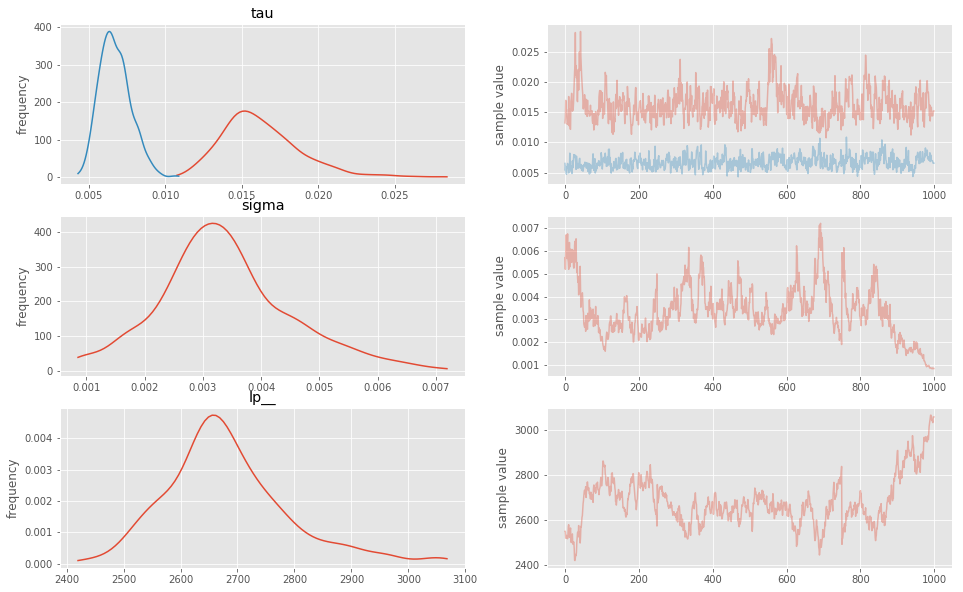

In [12]:
fit.plot(["tau","sigma","lp__"])
plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [13]:
#Compute error statistics of the model's imputations:# get mean and standard devitions for predictions
y_hat = samples["y_mis1"].mean(axis=0)
y_std = samples["y_mis1"].std(axis=0)

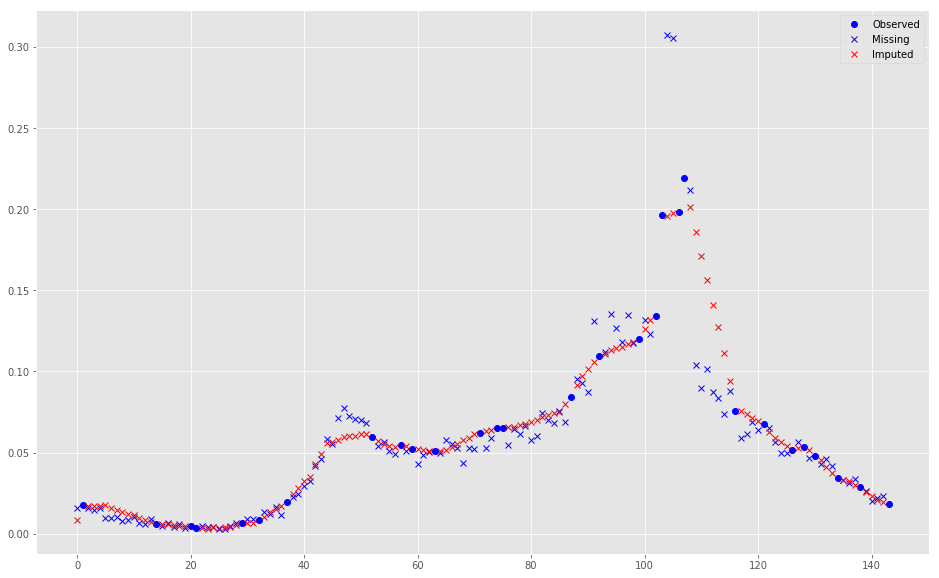

In [14]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["Observed", "Missing", "Imputed"]);

Compute error statistics of the model's imputations:

In [15]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [16]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.907
MAE: 0.00962
RMSE: 0.02125
R2: 0.821


Did you get a better result than with univariate LDS model from notebook 3? Compare the error statistics and the plots. You should have obtained a better result using the multivariate LDS. We could probably improve these results even further by:
- Consider even more correlated time-series (instead of just 2) and model their correlations in the multivariate LDS;
- Building more complex temporal dynamics, e.g. with higher order dependencies, with high dimensional latent states, different distributions, etc.